# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ac          1206 non-null   int64 
 1   cha         1206 non-null   int64 
 2   fortitude   1206 non-null   int64 
 3   reflex      1206 non-null   int64 
 4   dex         1206 non-null   int64 
 5   level       1206 non-null   int64 
 6   hp          1206 non-null   int64 
 7   con         1206 non-null   int64 
 8   int         1206 non-null   int64 
 9   str         1206 non-null   int64 
 10  focus       1206 non-null   int32 
 11  will        1206 non-null   int64 
 12  perception  1206 non-null   int64 
 13  wis         1206 non-null   int64 
 14  book        1206 non-null   object
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,ac,cha,fortitude,reflex,dex,level,hp,con,int,str,focus,will,perception,wis,book
0,29,1,22,19,2,10,215,5,1,7,1,17,20,2,Pathfinder Bestiary
1,28,1,21,14,0,10,220,5,-4,9,0,16,16,2,Pathfinder Bestiary
2,25,-2,20,17,3,8,175,6,-4,7,0,15,17,3,Pathfinder Bestiary
3,41,6,30,29,4,17,315,5,6,7,1,32,30,5,Pathfinder Bestiary
4,16,1,6,10,3,1,20,1,-1,-5,1,4,6,1,Pathfinder Bestiary


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


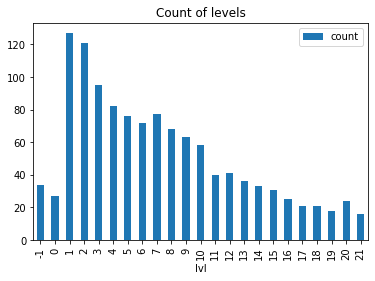

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.26
RMSE: 0.51
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "expanded", mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

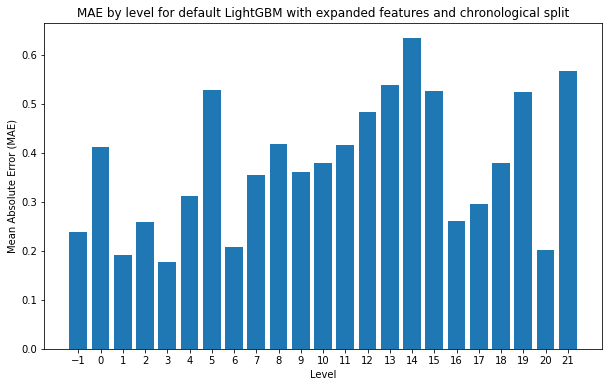

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Default:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.29
RMSE: 0.54



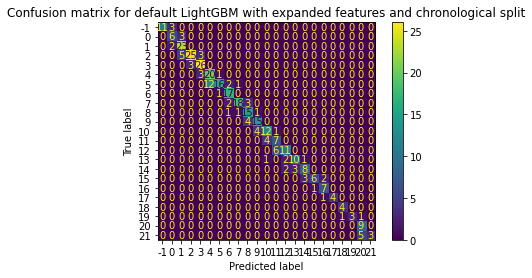

In [20]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with expanded features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 11:54:40,712] A new study created in memory with name: no-name-04736205-e502-4026-846a-31170586bcb3
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.188387 + 0.0381083
[200]	cv_agg's l2: 0.183812 + 0.035286
[300]	cv_agg's l2: 0.183635 + 0.0358472


feature_fraction, val_score: 0.183462:  14%|######4                                      | 1/7 [00:02<00:15,  2.50s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.183462 + 0.0357411
[100]	cv_agg's l2: 0.189416 + 0.0383436
[200]	cv_agg's l2: 0.186199 + 0.0363732
[300]	cv_agg's l2: 0.185652 + 0.0359814


feature_fraction, val_score: 0.183462:  29%|############8                                | 2/7 [00:04<00:12,  2.48s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.183462 + 0.0357411
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489


feature_fraction, val_score: 0.160904:  43%|###################2                         | 3/7 [00:06<00:08,  2.09s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.160904 + 0.0236687
[100]	cv_agg's l2: 0.184068 + 0.0427914
[200]	cv_agg's l2: 0.180847 + 0.04093


feature_fraction, val_score: 0.160904:  57%|#########################7                   | 4/7 [00:08<00:06,  2.12s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.160904 + 0.0236687
[100]	cv_agg's l2: 0.177655 + 0.0277536
[200]	cv_agg's l2: 0.174891 + 0.026591


feature_fraction, val_score: 0.160904:  71%|################################1            | 5/7 [00:11<00:04,  2.36s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.160904 + 0.0236687
[100]	cv_agg's l2: 0.186219 + 0.0455722
[200]	cv_agg's l2: 0.184163 + 0.0431044


feature_fraction, val_score: 0.160904:  86%|######################################5      | 6/7 [00:15<00:02,  2.91s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.160904 + 0.0236687
[100]	cv_agg's l2: 0.178359 + 0.0353854
[200]	cv_agg's l2: 0.174607 + 0.033989


feature_fraction, val_score: 0.160904: 100%|#############################################| 7/7 [00:18<00:00,  2.66s/it]


Early stopping, best iteration is:
[165]	cv_agg's l2: 0.160904 + 0.0236687


num_leaves, val_score: 0.160904:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489


num_leaves, val_score: 0.160904:   5%|##5                                               | 1/20 [00:02<00:53,  2.84s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.160904 + 0.0236687
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489


num_leaves, val_score: 0.160904:  10%|#####                                             | 2/20 [00:05<00:49,  2.74s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.160904 + 0.0236687
[100]	cv_agg's l2: 0.164995 + 0.0217877
[200]	cv_agg's l2: 0.160155 + 0.0220304
[300]	cv_agg's l2: 0.160033 + 0.0225136


num_leaves, val_score: 0.159628:  15%|#######5                                          | 3/20 [00:08<00:44,  2.64s/it]

[400]	cv_agg's l2: 0.16086 + 0.0233187
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.29367 + 0.0459977
[200]	cv_agg's l2: 0.260179 + 0.0401828


num_leaves, val_score: 0.159628:  15%|#######5                                          | 3/20 [00:08<00:44,  2.64s/it]

[300]	cv_agg's l2: 0.251466 + 0.036253
[400]	cv_agg's l2: 0.24556 + 0.0333715
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021


num_leaves, val_score: 0.159628:  20%|##########                                        | 4/20 [00:08<00:29,  1.86s/it]

[100]	cv_agg's l2: 0.248226 + 0.0261261
[200]	cv_agg's l2: 0.215614 + 0.0184476
[300]	cv_agg's l2: 0.200772 + 0.0145781
[400]	cv_agg's l2: 0.193125 + 0.0118465


num_leaves, val_score: 0.159628:  25%|############5                                     | 5/20 [00:09<00:22,  1.50s/it]

Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  30%|###############                                   | 6/20 [00:13<00:34,  2.49s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  35%|#################5                                | 7/20 [00:18<00:41,  3.16s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  40%|####################                              | 8/20 [00:22<00:41,  3.46s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  45%|######################5                           | 9/20 [00:26<00:40,  3.67s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  45%|######################5                           | 9/20 [00:30<00:40,  3.67s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021


num_leaves, val_score: 0.159628:  50%|########################5                        | 10/20 [00:30<00:38,  3.82s/it]

[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  55%|##########################9                      | 11/20 [00:34<00:35,  3.89s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  60%|#############################4                   | 12/20 [00:39<00:32,  4.04s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556
[400]	cv_agg's l2: 0.161764 + 0.0240931


num_leaves, val_score: 0.159628:  65%|###############################8                 | 13/20 [00:44<00:30,  4.38s/it]

Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556
[400]	cv_agg's l2: 0.161764 + 0.0240931


num_leaves, val_score: 0.159628:  70%|##################################3              | 14/20 [00:49<00:26,  4.45s/it]

Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  70%|##################################3              | 14/20 [00:56<00:26,  4.45s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021


num_leaves, val_score: 0.159628:  75%|####################################7            | 15/20 [00:56<00:26,  5.35s/it]

[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  80%|#######################################2         | 16/20 [01:02<00:21,  5.38s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  85%|#########################################6       | 17/20 [01:06<00:15,  5.05s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  85%|#########################################6       | 17/20 [01:10<00:15,  5.05s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021


num_leaves, val_score: 0.159628:  90%|############################################1    | 18/20 [01:10<00:09,  4.81s/it]

[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  95%|##############################################5  | 19/20 [01:15<00:04,  4.74s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164558 + 0.0241803
[200]	cv_agg's l2: 0.161615 + 0.0235489
[300]	cv_agg's l2: 0.161371 + 0.023556


num_leaves, val_score: 0.159628:  95%|##############################################5  | 19/20 [01:19<00:04,  4.74s/it]

[400]	cv_agg's l2: 0.161764 + 0.0240931
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021


bagging, val_score: 0.159628:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.206633 + 0.0334187
[200]	cv_agg's l2: 0.200925 + 0.028563
[300]	cv_agg's l2: 0.19947 + 0.02772


bagging, val_score: 0.159628:  10%|#####3                                               | 1/10 [00:02<00:24,  2.74s/it]

[400]	cv_agg's l2: 0.202133 + 0.0277718
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.165951 + 0.0210833
[200]	cv_agg's l2: 0.159862 + 0.0199099
[300]	cv_agg's l2: 0.160352 + 0.0207571


bagging, val_score: 0.159628:  20%|##########6                                          | 2/10 [00:05<00:22,  2.77s/it]

[400]	cv_agg's l2: 0.160845 + 0.0220216
Early stopping, best iteration is:
[313]	cv_agg's l2: 0.159628 + 0.0223021
[100]	cv_agg's l2: 0.164807 + 0.0201053
[200]	cv_agg's l2: 0.159507 + 0.0201805


bagging, val_score: 0.159507:  30%|###############9                                     | 3/10 [00:07<00:17,  2.46s/it]

[300]	cv_agg's l2: 0.160543 + 0.020419
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.159507 + 0.0201805
[100]	cv_agg's l2: 0.166717 + 0.020627
[200]	cv_agg's l2: 0.162444 + 0.0210739


bagging, val_score: 0.159507:  40%|#####################2                               | 4/10 [00:09<00:13,  2.28s/it]

[300]	cv_agg's l2: 0.161762 + 0.0210635
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.159507 + 0.0201805
[100]	cv_agg's l2: 0.163926 + 0.0192365
[200]	cv_agg's l2: 0.158411 + 0.0202278
[300]	cv_agg's l2: 0.157511 + 0.0208994


bagging, val_score: 0.157501:  50%|##########################5                          | 5/10 [00:12<00:12,  2.43s/it]

Early stopping, best iteration is:
[299]	cv_agg's l2: 0.157501 + 0.0209105
[100]	cv_agg's l2: 0.166275 + 0.0233109
[200]	cv_agg's l2: 0.161389 + 0.0221712
[300]	cv_agg's l2: 0.161647 + 0.0225315


bagging, val_score: 0.157501:  60%|###############################8                     | 6/10 [00:14<00:09,  2.48s/it]

Early stopping, best iteration is:
[299]	cv_agg's l2: 0.157501 + 0.0209105
[100]	cv_agg's l2: 0.165216 + 0.0204801
[200]	cv_agg's l2: 0.160777 + 0.0201794
[300]	cv_agg's l2: 0.161303 + 0.0211145


bagging, val_score: 0.157501:  70%|#####################################                | 7/10 [00:19<00:09,  3.12s/it]

Early stopping, best iteration is:
[299]	cv_agg's l2: 0.157501 + 0.0209105
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157888 + 0.0179912


bagging, val_score: 0.157457:  80%|##########################################4          | 8/10 [00:21<00:05,  2.84s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427
[100]	cv_agg's l2: 0.168738 + 0.0223137
[200]	cv_agg's l2: 0.164046 + 0.0186673


bagging, val_score: 0.157457:  90%|###############################################7     | 9/10 [00:23<00:02,  2.66s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427
[100]	cv_agg's l2: 0.169476 + 0.0232617
[200]	cv_agg's l2: 0.162758 + 0.0186583


bagging, val_score: 0.157457: 100%|####################################################| 10/10 [00:26<00:00,  2.63s/it]


Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427


feature_fraction_stage2, val_score: 0.157457:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.175658 + 0.0237592
[200]	cv_agg's l2: 0.168929 + 0.0221629


feature_fraction_stage2, val_score: 0.157457:  33%|############6                         | 1/3 [00:03<00:06,  3.11s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427
[100]	cv_agg's l2: 0.175658 + 0.0237592
[200]	cv_agg's l2: 0.168929 + 0.0221629


feature_fraction_stage2, val_score: 0.157457:  67%|#########################3            | 2/3 [00:05<00:02,  2.56s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157888 + 0.0179912


feature_fraction_stage2, val_score: 0.157457: 100%|######################################| 3/3 [00:07<00:00,  2.39s/it]


Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427


regularization_factors, val_score: 0.157457:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.166033 + 0.0225443
[200]	cv_agg's l2: 0.158855 + 0.0186825


regularization_factors, val_score: 0.157457:   5%|#9                                    | 1/20 [00:02<00:48,  2.54s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427
[100]	cv_agg's l2: 0.169153 + 0.0219094
[200]	cv_agg's l2: 0.161789 + 0.0200521


regularization_factors, val_score: 0.157457:  10%|###8                                  | 2/20 [00:05<00:47,  2.61s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427
[100]	cv_agg's l2: 0.176357 + 0.0242541
[200]	cv_agg's l2: 0.165044 + 0.021093


regularization_factors, val_score: 0.157457:  15%|#####7                                | 3/20 [00:07<00:43,  2.53s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427
[100]	cv_agg's l2: 0.181519 + 0.0241297
[200]	cv_agg's l2: 0.173022 + 0.0224684


regularization_factors, val_score: 0.157457:  20%|#######6                              | 4/20 [00:08<00:31,  1.98s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.157457 + 0.0187427
[100]	cv_agg's l2: 0.163611 + 0.0221343
[200]	cv_agg's l2: 0.156861 + 0.0185636
[300]	cv_agg's l2: 0.155851 + 0.0174546
[400]	cv_agg's l2: 0.156161 + 0.0163024


regularization_factors, val_score: 0.155535:  25%|#########5                            | 5/20 [00:12<00:37,  2.49s/it]

[500]	cv_agg's l2: 0.15666 + 0.0169884
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16421 + 0.0225199
[200]	cv_agg's l2: 0.159041 + 0.0190277
[300]	cv_agg's l2: 0.158421 + 0.0176813
[400]	cv_agg's l2: 0.158658 + 0.0167148


regularization_factors, val_score: 0.155535:  30%|###########4                          | 6/20 [00:15<00:39,  2.82s/it]

[500]	cv_agg's l2: 0.158969 + 0.0165467
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.164572 + 0.0216926
[200]	cv_agg's l2: 0.157716 + 0.0192502
[300]	cv_agg's l2: 0.158245 + 0.0173021
[400]	cv_agg's l2: 0.159016 + 0.0159544


regularization_factors, val_score: 0.155535:  35%|#############3                        | 7/20 [00:18<00:38,  2.93s/it]

[500]	cv_agg's l2: 0.159781 + 0.0158536
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.164152 + 0.0213192
[200]	cv_agg's l2: 0.157351 + 0.0190603
[300]	cv_agg's l2: 0.157311 + 0.0168368
[400]	cv_agg's l2: 0.158374 + 0.0155101


regularization_factors, val_score: 0.155535:  40%|###############2                      | 8/20 [00:22<00:36,  3.07s/it]

[500]	cv_agg's l2: 0.158867 + 0.0155092
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16448 + 0.0223723
[200]	cv_agg's l2: 0.15706 + 0.0181037
[300]	cv_agg's l2: 0.157006 + 0.0168934
[400]	cv_agg's l2: 0.156847 + 0.0152284


regularization_factors, val_score: 0.155535:  45%|#################1                    | 9/20 [00:26<00:36,  3.32s/it]

[500]	cv_agg's l2: 0.157441 + 0.0152151
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157959 + 0.0180178
[300]	cv_agg's l2: 0.157722 + 0.0168026
[400]	cv_agg's l2: 0.157332 + 0.015134


regularization_factors, val_score: 0.155535:  50%|##################5                  | 10/20 [00:30<00:37,  3.77s/it]

[500]	cv_agg's l2: 0.157727 + 0.0152829
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157959 + 0.0180178
[300]	cv_agg's l2: 0.157722 + 0.0168026
[400]	cv_agg's l2: 0.157332 + 0.015134


regularization_factors, val_score: 0.155535:  55%|####################3                | 11/20 [00:34<00:32,  3.65s/it]

[500]	cv_agg's l2: 0.157727 + 0.0152829
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157959 + 0.0180178
[300]	cv_agg's l2: 0.157722 + 0.0168026
[400]	cv_agg's l2: 0.157332 + 0.015134


regularization_factors, val_score: 0.155535:  60%|######################2              | 12/20 [00:37<00:29,  3.65s/it]

[500]	cv_agg's l2: 0.157727 + 0.0152829
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157959 + 0.0180178
[300]	cv_agg's l2: 0.157722 + 0.0168026
[400]	cv_agg's l2: 0.157332 + 0.015134


regularization_factors, val_score: 0.155535:  65%|########################             | 13/20 [00:41<00:24,  3.51s/it]

[500]	cv_agg's l2: 0.157727 + 0.0152829
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157959 + 0.0180178
[300]	cv_agg's l2: 0.157722 + 0.0168026
[400]	cv_agg's l2: 0.157332 + 0.015134


regularization_factors, val_score: 0.155535:  70%|#########################9           | 14/20 [00:44<00:21,  3.52s/it]

[500]	cv_agg's l2: 0.157727 + 0.0152829
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157959 + 0.0180178
[300]	cv_agg's l2: 0.157722 + 0.0168026
[400]	cv_agg's l2: 0.157332 + 0.015134


regularization_factors, val_score: 0.155535:  75%|###########################7         | 15/20 [00:49<00:19,  3.80s/it]

[500]	cv_agg's l2: 0.157727 + 0.0152829
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16449 + 0.0223714
[200]	cv_agg's l2: 0.157959 + 0.0180178
[300]	cv_agg's l2: 0.157722 + 0.0168026
[400]	cv_agg's l2: 0.157332 + 0.015134


regularization_factors, val_score: 0.155535:  80%|#############################6       | 16/20 [00:52<00:14,  3.67s/it]

[500]	cv_agg's l2: 0.157727 + 0.0152829
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16448 + 0.0223723
[200]	cv_agg's l2: 0.15706 + 0.0181037
[300]	cv_agg's l2: 0.157006 + 0.0168934
[400]	cv_agg's l2: 0.156829 + 0.0152138


regularization_factors, val_score: 0.155535:  85%|###############################4     | 17/20 [00:55<00:10,  3.54s/it]

[500]	cv_agg's l2: 0.157653 + 0.0154313
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16448 + 0.0223723
[200]	cv_agg's l2: 0.15706 + 0.0181037
[300]	cv_agg's l2: 0.157006 + 0.0168934
[400]	cv_agg's l2: 0.156847 + 0.0152284


regularization_factors, val_score: 0.155535:  90%|#################################3   | 18/20 [00:58<00:06,  3.41s/it]

[500]	cv_agg's l2: 0.157441 + 0.0152151
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.16448 + 0.0223723
[200]	cv_agg's l2: 0.15706 + 0.0181038
[300]	cv_agg's l2: 0.157006 + 0.0168934
[400]	cv_agg's l2: 0.15701 + 0.015218


regularization_factors, val_score: 0.155535:  95%|###################################1 | 19/20 [01:01<00:03,  3.36s/it]

[500]	cv_agg's l2: 0.158129 + 0.0151877
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663
[100]	cv_agg's l2: 0.164508 + 0.0223876
[200]	cv_agg's l2: 0.156677 + 0.0179544
[300]	cv_agg's l2: 0.15605 + 0.0162984
[400]	cv_agg's l2: 0.156325 + 0.0147211


regularization_factors, val_score: 0.155535: 100%|#####################################| 20/20 [01:05<00:00,  3.26s/it]


[500]	cv_agg's l2: 0.157496 + 0.0146252
Early stopping, best iteration is:
[410]	cv_agg's l2: 0.155535 + 0.0164663


min_data_in_leaf, val_score: 0.155535:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.147975 + 0.0237473
[200]	cv_agg's l2: 0.142808 + 0.0213842
[300]	cv_agg's l2: 0.14183 + 0.0217487
[400]	cv_agg's l2: 0.142242 + 0.0205456


min_data_in_leaf, val_score: 0.141526:  20%|#########                                    | 1/5 [00:03<00:14,  3.52s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.141526 + 0.0210292
[100]	cv_agg's l2: 0.149741 + 0.0241705
[200]	cv_agg's l2: 0.145227 + 0.0210122
[300]	cv_agg's l2: 0.144178 + 0.0212226
[400]	cv_agg's l2: 0.144701 + 0.0206527


min_data_in_leaf, val_score: 0.141526:  40%|##################                           | 2/5 [00:06<00:09,  3.12s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.141526 + 0.0210292
[100]	cv_agg's l2: 0.925012 + 0.164708
[200]	cv_agg's l2: 0.881946 + 0.15524
[300]	cv_agg's l2: 0.863683 + 0.152259


min_data_in_leaf, val_score: 0.141526:  60%|###########################                  | 3/5 [00:07<00:04,  2.24s/it]

[400]	cv_agg's l2: 0.852333 + 0.150051
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.141526 + 0.0210292
[100]	cv_agg's l2: 0.269651 + 0.0454508
[200]	cv_agg's l2: 0.253016 + 0.0506443
[300]	cv_agg's l2: 0.245083 + 0.0515958


min_data_in_leaf, val_score: 0.141526:  60%|###########################                  | 3/5 [00:09<00:04,  2.24s/it]

[400]	cv_agg's l2: 0.241809 + 0.0528309
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.141526 + 0.0210292


min_data_in_leaf, val_score: 0.141526:  80%|####################################         | 4/5 [00:09<00:02,  2.10s/it]

[100]	cv_agg's l2: 0.175561 + 0.0244155
[200]	cv_agg's l2: 0.171495 + 0.020947
[300]	cv_agg's l2: 0.170914 + 0.0187882
[400]	cv_agg's l2: 0.171588 + 0.0162287


min_data_in_leaf, val_score: 0.141526: 100%|#############################################| 5/5 [00:12<00:00,  2.43s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.141526 + 0.0210292


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14152569145764993
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.001260361002618118
    lambda_l2: 0.0007982138969493393
    num_leaves: 14
    feature_fraction: 0.4
    bagging_fraction: 0.8467319743744884
    bagging_freq: 5
    min_child_samples: 5


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.45
MSE test: 0.20
MAE test: 0.32



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "expanded",
    mse,
    rmse,
    mae,
]

###### MAE by level

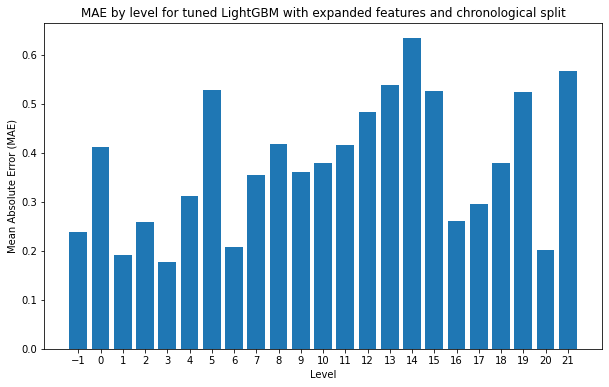

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
MSE: 0.20
RMSE: 0.45

Round type: round
MSE: 0.24
RMSE: 0.49

Round type: 0.33
MSE: 0.26
RMSE: 0.51

Round type: 0.45
MSE: 0.21
RMSE: 0.46



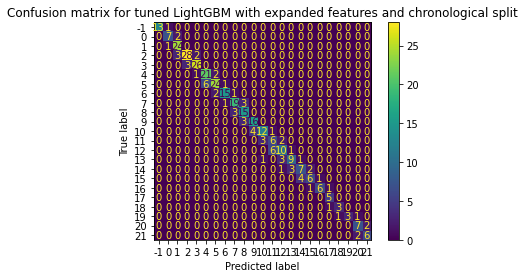

In [29]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with expanded features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.148111	valid_0's l1: 0.267273


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.15
RMSE: 0.38
MAE: 0.27


In [33]:
results.loc[2] = ["random", "default", "expanded", mse, rmse, mae]

###### MAE by level

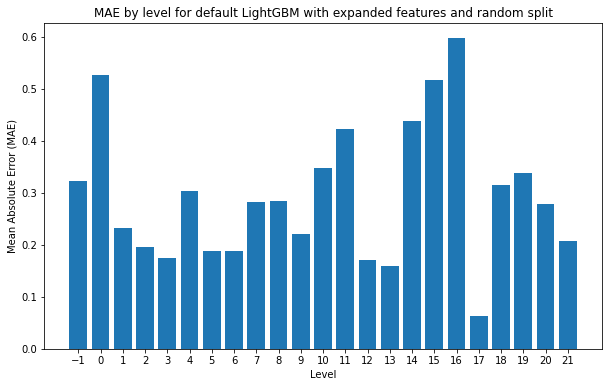

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and random split",
)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
MSE: 0.15
RMSE: 0.38

Round type: round
MSE: 0.15
RMSE: 0.39

Round type: 0.33
MSE: 0.21
RMSE: 0.45

Round type: 0.45
MSE: 0.17
RMSE: 0.41



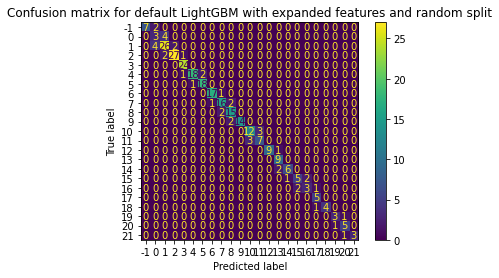

In [36]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with expanded features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 11:58:29,908] A new study created in memory with name: no-name-bd4efa51-abb8-4215-a47e-56095eb9342e
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.188072 + 0.0457642
[200]	cv_agg's l2: 0.186497 + 0.0438563


feature_fraction, val_score: 0.185960:  14%|######4                                      | 1/7 [00:02<00:16,  2.83s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.18596 + 0.0447527
[100]	cv_agg's l2: 0.194818 + 0.0452881
[200]	cv_agg's l2: 0.192044 + 0.0433607


feature_fraction, val_score: 0.185960:  29%|############8                                | 2/7 [00:05<00:13,  2.77s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.18596 + 0.0447527
[100]	cv_agg's l2: 0.187516 + 0.0462029
[200]	cv_agg's l2: 0.184862 + 0.0421903


feature_fraction, val_score: 0.184630:  43%|###################2                         | 3/7 [00:08<00:11,  2.84s/it]

[300]	cv_agg's l2: 0.185448 + 0.0420193
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.18463 + 0.0420585
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


feature_fraction, val_score: 0.164484:  57%|#########################7                   | 4/7 [00:11<00:08,  2.91s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.177883 + 0.0287942
[200]	cv_agg's l2: 0.17697 + 0.0272343


feature_fraction, val_score: 0.164484:  71%|################################1            | 5/7 [00:14<00:05,  3.00s/it]

[300]	cv_agg's l2: 0.177553 + 0.0259242
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.19126 + 0.0474681
[200]	cv_agg's l2: 0.187768 + 0.044865


feature_fraction, val_score: 0.164484:  86%|######################################5      | 6/7 [00:17<00:03,  3.06s/it]

[300]	cv_agg's l2: 0.187773 + 0.0433647
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.185935 + 0.0497008
[200]	cv_agg's l2: 0.183377 + 0.0477314
[300]	cv_agg's l2: 0.184366 + 0.0476669


feature_fraction, val_score: 0.164484: 100%|#############################################| 7/7 [00:20<00:00,  2.99s/it]


Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277


num_leaves, val_score: 0.164484:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201
[300]	cv_agg's l2: 0.165197 + 0.0340837


num_leaves, val_score: 0.164484:   5%|##5                                               | 1/20 [00:03<01:11,  3.78s/it]

Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201
[300]	cv_agg's l2: 0.165197 + 0.0340837


num_leaves, val_score: 0.164484:  10%|#####                                             | 2/20 [00:08<01:21,  4.54s/it]

Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  15%|#######5                                          | 3/20 [00:12<01:13,  4.34s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.309127 + 0.0892931
[200]	cv_agg's l2: 0.27157 + 0.0741328


num_leaves, val_score: 0.164484:  20%|##########                                        | 4/20 [00:13<00:45,  2.85s/it]

[300]	cv_agg's l2: 0.259582 + 0.0669682
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  25%|############5                                     | 5/20 [00:17<00:49,  3.27s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  30%|###############                                   | 6/20 [00:21<00:46,  3.35s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  35%|#################5                                | 7/20 [00:24<00:44,  3.41s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  40%|####################                              | 8/20 [00:27<00:40,  3.34s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  45%|######################5                           | 9/20 [00:31<00:36,  3.36s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  50%|########################5                        | 10/20 [00:34<00:33,  3.32s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  55%|##########################9                      | 11/20 [00:37<00:29,  3.31s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  60%|#############################4                   | 12/20 [00:41<00:27,  3.48s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  65%|###############################8                 | 13/20 [00:44<00:23,  3.37s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  70%|##################################3              | 14/20 [00:47<00:20,  3.36s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  70%|##################################3              | 14/20 [00:51<00:20,  3.36s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277


num_leaves, val_score: 0.164484:  75%|####################################7            | 15/20 [00:51<00:16,  3.37s/it]

[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  80%|#######################################2         | 16/20 [00:55<00:13,  3.46s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  85%|#########################################6       | 17/20 [00:58<00:10,  3.36s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  90%|############################################1    | 18/20 [01:01<00:06,  3.49s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  95%|##############################################5  | 19/20 [01:05<00:03,  3.39s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.167019 + 0.0327348
[200]	cv_agg's l2: 0.164581 + 0.0330201


num_leaves, val_score: 0.164484:  95%|##############################################5  | 19/20 [01:08<00:03,  3.39s/it]

[300]	cv_agg's l2: 0.165197 + 0.0340837
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277


bagging, val_score: 0.164484:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.17989 + 0.0280341
[200]	cv_agg's l2: 0.173048 + 0.0237556


bagging, val_score: 0.164484:  10%|#####3                                               | 1/10 [00:02<00:19,  2.16s/it]

[300]	cv_agg's l2: 0.174416 + 0.0226709
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.164484 + 0.0329277
[100]	cv_agg's l2: 0.165861 + 0.0324864
[200]	cv_agg's l2: 0.164272 + 0.0312748


bagging, val_score: 0.163693:  20%|##########6                                          | 2/10 [00:05<00:23,  2.90s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.163693 + 0.0311083
[100]	cv_agg's l2: 0.161638 + 0.0292013
[200]	cv_agg's l2: 0.160027 + 0.0292829


bagging, val_score: 0.159549:  30%|###############9                                     | 3/10 [00:08<00:21,  3.06s/it]

Early stopping, best iteration is:
[183]	cv_agg's l2: 0.159549 + 0.0293812
[100]	cv_agg's l2: 0.162055 + 0.0312034
[200]	cv_agg's l2: 0.160891 + 0.0306029


bagging, val_score: 0.159549:  40%|#####################2                               | 4/10 [00:11<00:18,  3.09s/it]

Early stopping, best iteration is:
[183]	cv_agg's l2: 0.159549 + 0.0293812
[100]	cv_agg's l2: 0.159873 + 0.026131
[200]	cv_agg's l2: 0.158248 + 0.0253222


bagging, val_score: 0.157768:  50%|##########################5                          | 5/10 [00:14<00:15,  3.04s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202
[100]	cv_agg's l2: 0.16381 + 0.0325746
[200]	cv_agg's l2: 0.162619 + 0.0333559


bagging, val_score: 0.157768:  60%|###############################8                     | 6/10 [00:17<00:11,  2.95s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202
[100]	cv_agg's l2: 0.164684 + 0.03023
[200]	cv_agg's l2: 0.161406 + 0.028545


bagging, val_score: 0.157768:  70%|#####################################                | 7/10 [00:20<00:08,  2.86s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202
[100]	cv_agg's l2: 0.162332 + 0.0311158
[200]	cv_agg's l2: 0.161633 + 0.0312209


bagging, val_score: 0.157768:  80%|##########################################4          | 8/10 [00:23<00:05,  2.81s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202
[100]	cv_agg's l2: 0.162439 + 0.0307305
[200]	cv_agg's l2: 0.159998 + 0.0297251


bagging, val_score: 0.157768:  90%|###############################################7     | 9/10 [00:25<00:02,  2.79s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202
[100]	cv_agg's l2: 0.170536 + 0.0285401
[200]	cv_agg's l2: 0.167893 + 0.0258377


bagging, val_score: 0.157768: 100%|####################################################| 10/10 [00:28<00:00,  2.83s/it]


Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202


feature_fraction_stage2, val_score: 0.157768:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.159873 + 0.026131
[200]	cv_agg's l2: 0.158248 + 0.0253222


feature_fraction_stage2, val_score: 0.157768:  33%|############6                         | 1/3 [00:02<00:05,  2.74s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202
[100]	cv_agg's l2: 0.166499 + 0.027102
[200]	cv_agg's l2: 0.165835 + 0.0259237


feature_fraction_stage2, val_score: 0.157768:  67%|#########################3            | 2/3 [00:05<00:02,  2.74s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202
[100]	cv_agg's l2: 0.166499 + 0.027102
[200]	cv_agg's l2: 0.165835 + 0.0259237


feature_fraction_stage2, val_score: 0.157768: 100%|######################################| 3/3 [00:08<00:00,  2.68s/it]


Early stopping, best iteration is:
[186]	cv_agg's l2: 0.157768 + 0.0254202


regularization_factors, val_score: 0.157768:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.158057 + 0.0263478
[200]	cv_agg's l2: 0.15728 + 0.0264617


regularization_factors, val_score: 0.156834:   5%|#9                                    | 1/20 [00:02<00:50,  2.68s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.156834 + 0.0265103
[100]	cv_agg's l2: 0.15841 + 0.0260129
[200]	cv_agg's l2: 0.157543 + 0.0261497


regularization_factors, val_score: 0.156834:  10%|###8                                  | 2/20 [00:05<00:48,  2.69s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.156834 + 0.0265103
[100]	cv_agg's l2: 0.158057 + 0.0263478
[200]	cv_agg's l2: 0.157262 + 0.026469


regularization_factors, val_score: 0.156834:  15%|#####7                                | 3/20 [00:08<00:45,  2.68s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.156834 + 0.0265103
[100]	cv_agg's l2: 0.158463 + 0.0269584
[200]	cv_agg's l2: 0.157683 + 0.0272784


regularization_factors, val_score: 0.156834:  20%|#######6                              | 4/20 [00:10<00:43,  2.74s/it]

Early stopping, best iteration is:
[191]	cv_agg's l2: 0.156834 + 0.0265103
[100]	cv_agg's l2: 0.15764 + 0.0266566
[200]	cv_agg's l2: 0.157488 + 0.0274374


regularization_factors, val_score: 0.156602:  25%|#########5                            | 5/20 [00:13<00:38,  2.59s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.156602 + 0.0270252
[100]	cv_agg's l2: 0.158089 + 0.026332
[200]	cv_agg's l2: 0.157584 + 0.0273587


regularization_factors, val_score: 0.156602:  30%|###########4                          | 6/20 [00:15<00:35,  2.51s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.156602 + 0.0270252
[100]	cv_agg's l2: 0.158057 + 0.0263478
[200]	cv_agg's l2: 0.15728 + 0.0264617


regularization_factors, val_score: 0.156602:  35%|#############3                        | 7/20 [00:17<00:31,  2.45s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.156602 + 0.0270252
[100]	cv_agg's l2: 0.158247 + 0.0261746
[200]	cv_agg's l2: 0.157452 + 0.0264208


regularization_factors, val_score: 0.156602:  40%|###############2                      | 8/20 [00:20<00:28,  2.38s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.156602 + 0.0270252
[100]	cv_agg's l2: 0.158462 + 0.0269583
[200]	cv_agg's l2: 0.157683 + 0.0271098


regularization_factors, val_score: 0.156602:  45%|#################1                    | 9/20 [00:22<00:26,  2.43s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.156602 + 0.0270252
[100]	cv_agg's l2: 0.158247 + 0.0261745
[200]	cv_agg's l2: 0.157452 + 0.0264208


regularization_factors, val_score: 0.156602:  50%|##################5                  | 10/20 [00:25<00:25,  2.60s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.156602 + 0.0270252
[100]	cv_agg's l2: 0.157973 + 0.0262675
[200]	cv_agg's l2: 0.157588 + 0.0258523


regularization_factors, val_score: 0.156602:  55%|####################3                | 11/20 [00:28<00:23,  2.64s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.156602 + 0.0270252
[100]	cv_agg's l2: 0.158641 + 0.0266224
[200]	cv_agg's l2: 0.157205 + 0.0262869


regularization_factors, val_score: 0.156602:  60%|######################2              | 12/20 [00:31<00:21,  2.65s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.156602 + 0.0270252
[100]	cv_agg's l2: 0.158376 + 0.0256322
[200]	cv_agg's l2: 0.156245 + 0.0256261


regularization_factors, val_score: 0.156245:  65%|########################             | 13/20 [00:33<00:18,  2.67s/it]

[300]	cv_agg's l2: 0.158134 + 0.0264026
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.156245 + 0.0256261
[100]	cv_agg's l2: 0.158491 + 0.0263862
[200]	cv_agg's l2: 0.157687 + 0.0263055


regularization_factors, val_score: 0.156245:  70%|#########################9           | 14/20 [00:36<00:16,  2.73s/it]

[300]	cv_agg's l2: 0.15888 + 0.0274572
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.156245 + 0.0256261
[100]	cv_agg's l2: 0.15989 + 0.0268528
[200]	cv_agg's l2: 0.158532 + 0.0265635


regularization_factors, val_score: 0.156245:  75%|###########################7         | 15/20 [00:39<00:13,  2.79s/it]

[300]	cv_agg's l2: 0.16027 + 0.0270585
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.156245 + 0.0256261
[100]	cv_agg's l2: 0.158088 + 0.0265241
[200]	cv_agg's l2: 0.156905 + 0.0260132


regularization_factors, val_score: 0.156245:  80%|#############################6       | 16/20 [00:42<00:11,  2.80s/it]

[300]	cv_agg's l2: 0.15913 + 0.0265278
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.156245 + 0.0256261
[100]	cv_agg's l2: 0.158088 + 0.0265241
[200]	cv_agg's l2: 0.156905 + 0.0260131


regularization_factors, val_score: 0.156245:  85%|###############################4     | 17/20 [00:45<00:08,  2.79s/it]

[300]	cv_agg's l2: 0.158862 + 0.0260395
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.156245 + 0.0256261
[100]	cv_agg's l2: 0.158088 + 0.0265239
[200]	cv_agg's l2: 0.156905 + 0.0260129


regularization_factors, val_score: 0.156245:  90%|#################################3   | 18/20 [00:47<00:05,  2.78s/it]

[300]	cv_agg's l2: 0.159063 + 0.0265807
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.156245 + 0.0256261
[100]	cv_agg's l2: 0.160625 + 0.0239418
[200]	cv_agg's l2: 0.158762 + 0.0238051


regularization_factors, val_score: 0.156245:  95%|###################################1 | 19/20 [00:50<00:02,  2.79s/it]

[300]	cv_agg's l2: 0.160557 + 0.0250631
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.156245 + 0.0256261
[100]	cv_agg's l2: 0.159004 + 0.0267692
[200]	cv_agg's l2: 0.157972 + 0.0263532


regularization_factors, val_score: 0.156245: 100%|#####################################| 20/20 [00:53<00:00,  2.67s/it]


[300]	cv_agg's l2: 0.160741 + 0.027013
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.156245 + 0.0256261


min_data_in_leaf, val_score: 0.156245:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.15518 + 0.0266537
[200]	cv_agg's l2: 0.152673 + 0.0257271


min_data_in_leaf, val_score: 0.152583:  20%|#########                                    | 1/5 [00:03<00:13,  3.49s/it]

Early stopping, best iteration is:
[195]	cv_agg's l2: 0.152583 + 0.0260062
[100]	cv_agg's l2: 0.170319 + 0.0261393
[200]	cv_agg's l2: 0.167359 + 0.0268038


min_data_in_leaf, val_score: 0.152583:  40%|##################                           | 2/5 [00:05<00:08,  2.76s/it]

Early stopping, best iteration is:
[195]	cv_agg's l2: 0.152583 + 0.0260062
[100]	cv_agg's l2: 0.218744 + 0.0305702
[200]	cv_agg's l2: 0.214019 + 0.0289763


min_data_in_leaf, val_score: 0.152583:  60%|###########################                  | 3/5 [00:07<00:04,  2.10s/it]

Early stopping, best iteration is:
[195]	cv_agg's l2: 0.152583 + 0.0260062
[100]	cv_agg's l2: 0.668374 + 0.0736472
[200]	cv_agg's l2: 0.630013 + 0.0628809


min_data_in_leaf, val_score: 0.152583:  80%|####################################         | 4/5 [00:08<00:01,  1.66s/it]

Early stopping, best iteration is:
[195]	cv_agg's l2: 0.152583 + 0.0260062
[100]	cv_agg's l2: 0.162557 + 0.0246247
[200]	cv_agg's l2: 0.161808 + 0.0235645


min_data_in_leaf, val_score: 0.152583: 100%|#############################################| 5/5 [00:11<00:00,  2.28s/it]

Early stopping, best iteration is:
[195]	cv_agg's l2: 0.152583 + 0.0260062


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.15258347678857334
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 3.3665147461870125e-05
    lambda_l2: 0.0006825119541607033
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.976168004403553
    bagging_freq: 1
    min_child_samples: 10


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.33
MSE test: 0.11
MAE test: 0.23



In [41]:
results.loc[3] = ["random", "Optuna", "expanded", mse, rmse, mae]

###### MAE by level

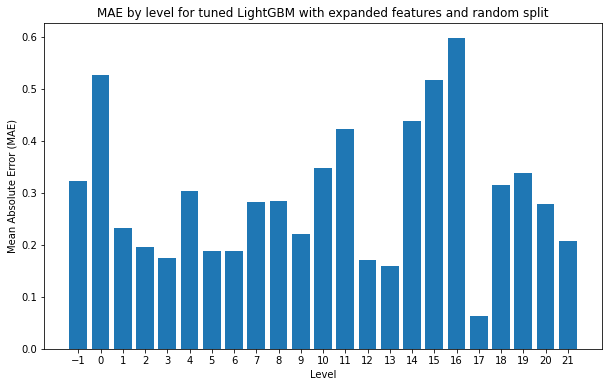

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
MSE: 0.04
RMSE: 0.19

Round type: round
MSE: 0.04
RMSE: 0.21

Round type: 0.33
MSE: 0.05
RMSE: 0.23

Round type: 0.45
MSE: 0.05
RMSE: 0.22



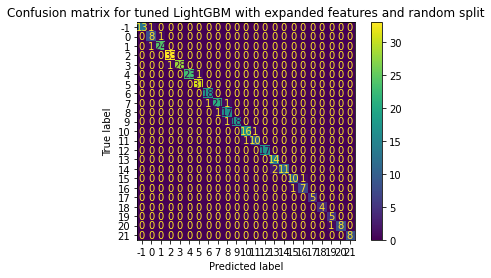

In [44]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with expanded features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,MSE,RMSE,MAE
0,chronological,default,expanded,0.260889,0.510773,0.357206
1,chronological,Optuna,expanded,0.198254,0.445257,0.322687
2,random,default,expanded,0.148111,0.384853,0.267273
3,random,Optuna,expanded,0.111273,0.333575,0.228666


In [46]:
from training.results import plot_summary

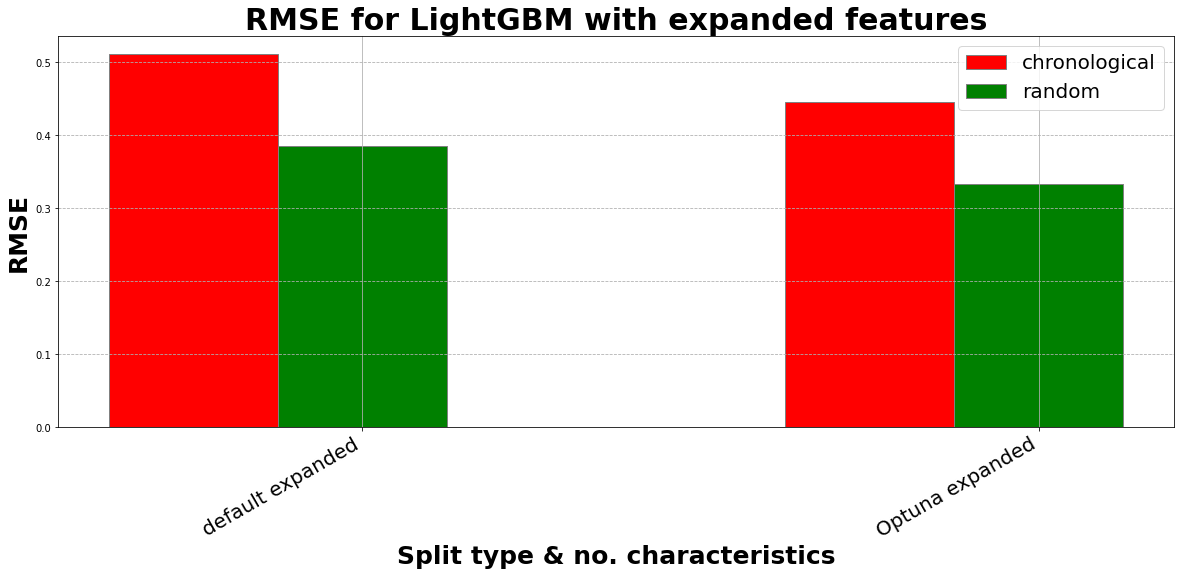

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with expanded features")

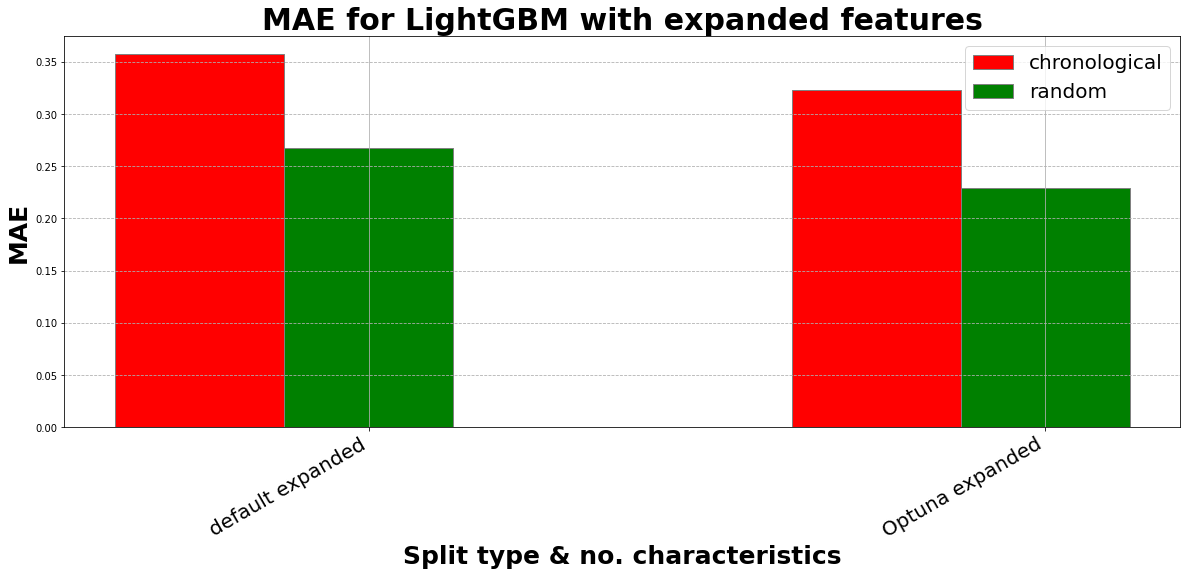

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with expanded features")

In [49]:
results.to_json("./lightgbm_expanded_results.json", indent=2)